# Logistic Regression with a NN mindset

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
#from PIL import image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

## Overview of the problem set

- cat이면 y=1, 아니면 y=0으로 구분하는 문제
- 각 이미지: height(num_px) * width(num_px) * channel(3)


### 데이터 불러오기, 확인

In [2]:
#데이터 불러오기
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


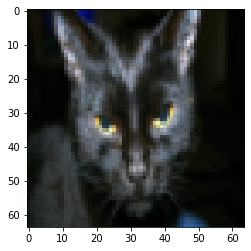

In [3]:
#데이터 예시 확인하기
index = 25
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [4]:
#데이터 구조 확인
print(train_set_x_orig.shape)
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)


### 이미지 reshape

- flattend image로 변경: (num_px, num_px, 3) > (num_px $*$ num_px $*$ 3, 1)

In [10]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [11]:
print(train_set_x_orig.shape)
print(64*64*3)
print(train_set_x_flatten.shape)

(209, 64, 64, 3)
12288
(12288, 209)


In [12]:
train_set_x_orig.reshape(train_set_x_orig.shape[0],-2)

array([[ 17,  31,  56, ...,   0,   0,   0],
       [196, 192, 190, ...,  82,  80,  81],
       [ 82,  71,  68, ..., 138, 141, 142],
       ...,
       [143, 155, 165, ...,  85, 107, 149],
       [ 22,  24,  23, ...,   4,   5,   0],
       [  8,  28,  53, ...,   0,   0,   0]], dtype=uint8)

In [13]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255

## General Architecture of the learning algorithm

Logistic Regresiion으로 고양이 구분하는 알고리즘 만들기
1. 이미지 한 장을 flatten하게 만듦
2. 각 행을 255로 나눠서 각 node에 값 입력
3. 각 노드에 각 weight를 곱해주고 bias를 더하여 z값 생성 - weight 초기화
4. z값에 sigmoid를 씌워서 output a 만듦
5. 이렇게 만들어진 a와 Cost Function을 최소화하는 weight 업데이트

## Building the parts of our algorithm

### Helper function 만들기 - Sigmoid

In [14]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [15]:
sigmoid(np.array([0,2])) #0과 2에 대해 각각 sigmoid 취해줌

array([0.5       , 0.88079708])

### parameters(weights, bias) 초기화 

In [26]:
def initialize_with_zeros(dim):
    w = np.zeros((dim,1)) #dim만큼의 행이 있는 (dim,1)의 영행렬 생성
    b = 0 #bias는 상수
    assert(w.shape == (dim,1)) #assert 뒤의 조건에 해당하지 않으면 AssertionError 발생
    assert(isinstance(b,float) or isinstance(b,int)) #데이터타입이 맞는지 확인
    return w,b

In [27]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### Foward and Backward Propagation

Forward Propagation
1. X를 input으로 받음
2. weight를 곱해주고 bias를 더해 Z를 얻음
3. X에 sigmoid를 취해 A를 얻음
4. A가 들어있는 cost function을 구함

Backward Propagation
1. w,b의 미분값인 dw,db를 구하기
2. (gradients 업데이트 하기)

In [32]:
def propagate(w, b, X, Y):
    m = X.shape[1] #데이터의 수
    
    ### Forward Propagation ###
    Z = np.dot(w.T,X)+b
    A = sigmoid(Z)
    cost = (-1/m)*(np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)))
    
    ### Backward Propagation ###
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*(np.sum(A-Y))
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost) #1차원인 축 모두 제거
    assert(cost.shape == ()) #?
    grads = {'dw':dw, 'db':db}
    
    return grads, cost    

In [33]:
w, b = np.array([[1.],[2.]]), 2.
X, Y = np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])

grads, cost = propagate(w, b, X, Y)

print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### Optimization

In [41]:
def optimize(w,b,X,Y, num_iterations,learning_rate, print_cost=False):
    costs = []
    for i in range(num_iterations):
        #변수 불러오기
        grads, cost = propagate(w,b,X,Y)
        dw = grads['dw']
        db = grads['db']
        
        #parameter 업데이트
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        #costs 기록 및 출력
        if i % 100 == 0: #반복 100번 할 때마다 기록
            costs.append(cost)
        if print_cost and i%100==0:
            print('Cost after iteration %i: %f' %(i,cost))
        
    #업데이트된 파라미터 저장
    parmas = {'w':w, 'b':b}
    grads = {'dw':dw, 'db':db}
        
    return parmas, grads, costs

In [42]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


### 예측

In [46]:
def predict(w,b, X):
    print('X.shape: ', X.shape)
    m = X.shape[1] #예측할 데이터의 수
    Y_prediction = np.zeros((1,m)) #데이터 수만큼 열이 있는 영행렬
    w = w.reshape(X.shape[0],1) #한 데이터당 노드(행)의 수
    
    A = sigmoid(np.dot(w.T,X) + b)
    print('A.shape: ', A.shape)
     
    for i in range(A.shape[1]): #데이터의 수만큼 반복
        Y_prediction[0][i] = 1 if A[0][i]>0.5 else 0
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [47]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

X.shape:  (2, 3)
A.shape:  (1, 3)
predictions = [[1. 1. 0.]]


## 하나의 모델로 합치기

In [56]:
def model(X_train,Y_train,X_test,Y_test, num_iterations=2000,learning_rate=0.5, print_cost=False):
    #1. 파라미터 초기화
    w,b = initialize_with_zeros(X_train.shape[0])
    
    #2. 파라미더 업데이트 (gradient descent)
    parameters, grads, costs = optimize(w,b, X_train,Y_train, num_iterations,learning_rate, print_cost = False)
    w = parameters['w']
    b = parameters['b']
    
    #3. 예측
    Y_prediction_test = predict(w,b, X_test)
    Y_prediction_train = predict(w,b, X_train)
    
    ## 프린트 ##
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    ## 결과 ##
    d = {'costs':costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [57]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

X.shape:  (12288, 50)
A.shape:  (1, 50)
X.shape:  (12288, 209)
A.shape:  (1, 209)
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


## (cost function)

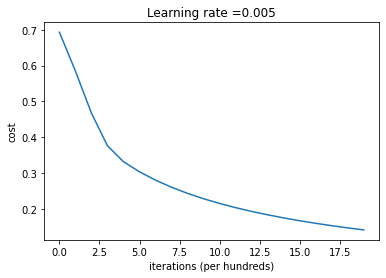

In [58]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()